In [ ]:
#Тематическое моделирование

#Наша цель выбрать какие-нибудь интересные аудитории и проанализировать каким именно контентом они интересуются. 
#На основе их интересов нужно попробовать нарисовать профили пользователей.


In [ ]:
#Паблик 1: https://vk.com/neewschool
#Паблик 2: https://vk.com/old_school_rus_rap
#Паблик 3: https://vk.com/official_guf_zm
#Паблик 4: https://vk.com/gonefan
#Паблик 5: https://vk.com/benzogang_tape

#Мы взяли 5 пабликов вк. Первый - фанаты новой школы репа, второй - старой. Третий - фанаты Гуфа (артист старой
#школы). Четвертый - GoneFludd (представитель новой школы репа). Пятый - Big Baby Tape (новая школа)
#Нам стало интересно, в чем их сходство и различие.
#Можно ли составить портрет фаната старой школы репа и новой?

In [18]:
import pickle
import requests
import time 
import numpy as np

In [32]:
# версия используемого API
version = '5.103' 

# подгружаем токен
with open('token.txt') as f:
    token = f.read()

#Выдает информацию о пользователе по методу
def vk_download(method, parameters):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + str(token) + '&v=' + version
    response = requests.get(url) 
    infa = response.json()
    return infa

In [35]:
#Наш датасет
data = {
    'NewSchool': 'neewschool',
    'GoneFludd': 'gonefan',
    'BigBabyTape': 'benzogang_tape',
    
    'OldSchool': 'old_school_rus_rap',
    'Guf': 'official_guf_zm'
}

In [36]:
print('Узнаем, сколько в группе человек')
for key in data.keys():
    cur_id = data[key]
    cur_infa = vk_download('groups.getMembers', 'group_id=' + str(cur_id))
    kol = cur_infa['response']['count']
    print(f'В {key} - {kol} человек')

Узнаем, сколько в группе человек
В NewSchool - 655935 человек
В GoneFludd - 24334 человек
В BigBabyTape - 588062 человек
В OldSchool - 33991 человек
В Guf - 303013 человек


In [37]:
%%time
#Выдает массив с 3000 id людей из группы
def group_members_download(cur_id):
    
    # Сколько всего в группе людей
    cur_infa = vk_download('groups.getMembers', 'group_id=' + str(cur_id))
    
    # стартовая точка
    start_offset = max(0, cur_infa['response']['count'] - 6000)

    infa = [] # сюда буду сохранять людей

    # качаем по 1000 штук по циклу
    for offset in range(start_offset, start_offset + 6000, 1000):

        time.sleep(0.4) # вк согласен работать 3 раза в секунду, 
                        # эта строка нужна, чтобы он не ругался 

        cur_infa = vk_download('groups.getMembers', 
                    'group_id=' + str(cur_id) + '&offset=' + str(offset))

        infa.extend(cur_infa['response']['items'])
    return infa

members = {} # сюда будем класть всех членов групп по очереди

#Закинем в members id пользователей каждой группы
for key, value in data.items():
    print('Качаю группу', key)
    infa = group_members_download(value)
    members[key] = infa 

Качаю группу NewSchool
Качаю группу GoneFludd
Качаю группу BigBabyTape
Качаю группу OldSchool
Качаю группу Guf
Wall time: 18.8 s


In [38]:
#Функция для очистки выборки
def filter_members(memes_id):
    
    # сделали id текстом
    memes_id_text = [str(item) for item in memes_id]
    
    clean_memes_id = [] # список для хорших id 
    
    # качаем информацию кусочками по 300 штук
    for i in range(len(memes_id_text)//300):
                
        time.sleep(0.4) # немного подождали, чтобы вк нас не банил
        
                                                         # взяли текущие 300 человек из списка
        infa = vk_download('users.get','user_ids=' + ','.join(memes_id_text[i*300:(i+1)*300]) + '&fields=last_seen')
 
        

        # чистим пользователей
        for item in infa['response']:

            try: # попробуй сделать вот это

                # если пользователь не удален, не приватный, а ещё недавно был в сети 
                if ('deactivated' not in item) and \
                   (item['is_closed'] == False) and \
                   (item['last_seen']['time'] >= time.time() - 30*24*60*60):

                            clean_memes_id.append(item) # запоминаем его 

            except:   # если питон говорит, что ошибся
                pass    
    return clean_memes_id # вернули из функции чистые id

In [39]:
%%time
clean_members = {} # сюда будем класть всех прочищеных членов групп по очереди

for key, value in members.items():
    print(f'Фильтрую id из группы - {key}')
    infa = filter_members(value)
    clean_members[key] = infa
    
del members

Фильтрую id из группы - NewSchool
Фильтрую id из группы - GoneFludd
Фильтрую id из группы - BigBabyTape
Фильтрую id из группы - OldSchool
Фильтрую id из группы - Guf
Wall time: 1min 10s


In [40]:
#Сохраняем наш массив очищенных id
with open('group_clean_members.pickle', 'wb') as f:
    pickle.dump(clean_members, f)

In [62]:
#clean_members - словарь, содержащий в ключах названия групп, а значения - массив id очищенных людей
#он уже сохранен в памяти, подгрузить можно следующим образом

# Подгрузить данные из файлика можно вот так: 
with open('group_clean_members.pickle', 'rb') as f:
    clean_members = pickle.load(f)

In [64]:
clean_members['BigBabyTape'] = clean_members['BigBabyTape'][500:2000]

In [65]:
print('clean_members')
print(f'Type - {type(clean_members)}')
print(f'Keys: {clean_members.keys()}')
for key in clean_members.keys():
    k = len(clean_members[key])
    print(f'В группе {key} осталось {k} участников')

clean_members
Type - <class 'dict'>
Keys: dict_keys(['NewSchool', 'GoneFludd', 'BigBabyTape', 'OldSchool', 'Guf'])
В группе NewSchool осталось 2768 участников
В группе GoneFludd осталось 2430 участников
В группе BigBabyTape осталось 1500 участников
В группе OldSchool осталось 2668 участников
В группе Guf осталось 2357 участников


In [48]:
#Выдает стену пользователя по id
def get_wall(user_id):
    wall = vk_download('wall.get', 'owner_id='+str(user_id)+'&count=100')
    
    try:
        # распаковали её
        wall = wall['response']['items']
        post_texts = [cur['text'] for cur in wall]
        repost_texts = [cur['copy_history'][0]['text'] if 'copy_history' in cur else '' for cur in wall]

        # соединили все посты и репосты в один длинный текст
        wall_text = ' '.join(post_texts) + ' '.join(repost_texts)
        return wall_text
    except:
        print(f'Возникла ошибка на пользователе {user_id}\nСтена:')
        print(wall)
        print()

In [ ]:
#Теперь скачаем все стены каждого паблика
#Будем скачивать каждый паблик в новой строчке, так как можно за раз скачать всего 5000 стен, а этого хватает
#на 1 паблик (некоторые стены выдают None, некоторые пустую строку и тд Их мы выкидываем из выборки)

In [ ]:
%%time
#Скачаем стены паблика NewSchool
key = 'NewSchool'
value = clean_members[key]
print('Качаю стены участников из группы', key)    
wall_members = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item['id'])
        
        if wall_text != None and len(wall_text) > 10:
            cur_item = {'group': key, 'id': item['id'], 'wall': wall_text}

            wall_members.append(cur_item)
    except:
        print('Ошибка!')
        print('Напиши get_wall(id)')

    # сохраняем итоговые тексты стенок для текущего сообщества 
with open('parsing_wall/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_members, f)

In [ ]:
%%time
#Скачаем стены паблика GoneFludd
key = 'GoneFludd'
value = clean_members[key]
print('Качаю стены участников из группы', key)    
wall_members = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item['id'])
        
        if wall_text != None and len(wall_text) > 10:
            cur_item = {'group': key, 'id': item['id'], 'wall': wall_text}

            wall_members.append(cur_item)
    except:
        print('Ошибка!')
        print('Напиши get_wall(id)')

    # сохраняем итоговые тексты стенок для текущего сообщества 
with open('parsing_wall/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_members, f)

In [ ]:
%%time
#Скачаем стены паблика OldSchool
key = 'OldSchool'
value = clean_members[key]
print('Качаю стены участников из группы', key)    
wall_members = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item['id'])
        
        if wall_text != None and len(wall_text) > 10:
            cur_item = {'group': key, 'id': item['id'], 'wall': wall_text}

            wall_members.append(cur_item)
    except:
        print('Ошибка!')
        print('Напиши get_wall(id)')

    # сохраняем итоговые тексты стенок для текущего сообщества 
with open('parsing_wall/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_members, f)

In [ ]:
%%time
#Скачаем стены паблика Guf
key = 'Guf'
value = clean_members[key]
print('Качаю стены участников из группы', key)    
wall_members = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item['id'])
        
        if wall_text != None and len(wall_text) > 10:
            cur_item = {'group': key, 'id': item['id'], 'wall': wall_text}

            wall_members.append(cur_item)
    except:
        print('Ошибка!')
        print('Напиши get_wall(id)')

    # сохраняем итоговые тексты стенок для текущего сообщества 
with open('parsing_wall/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_members, f)

In [66]:
%%time
#Скачаем стены паблика Guf
key = 'BigBabyTape'
value = clean_members[key]
print('Качаю стены участников из группы', key)    
wall_members = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item['id'])
        
        if wall_text != None and len(wall_text) > 10:
            cur_item = {'group': key, 'id': item['id'], 'wall': wall_text}

            wall_members.append(cur_item)
    except:
        print('Ошибка!')
        print('Напиши get_wall(id)')

    # сохраняем итоговые тексты стенок для текущего сообщества 
with open('parsing_wall/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_members, f)

Качаю стены участников из группы BigBabyTape
Wall time: 15min 17s


In [ ]:
#Теперь приступим к модели

In [79]:
import pandas as pd
from pymystem3 import Mystem

# Пакеты для графииков
import matplotlib
import matplotlib.pyplot as plt                             
import seaborn as sns
plt.style.use('ggplot')   # Правильный стиль графиков   

%matplotlib inline

In [80]:
#Построим графики и посмотрим, какое количество слов в скачанных данных
#По x - количество слов в посте, по y - количество повторений

Кол-во: 2773
NewSchool
Оставшееся кол-во постов: 1129


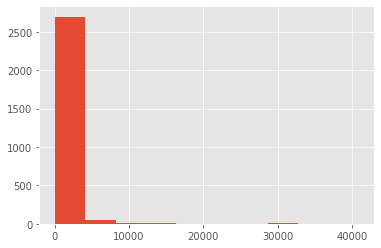

In [81]:
#Для NewSchool
# Подгрузим данные из файлика 
with open('parsing_wall/NewSchool.pickle', 'rb') as f:
    wall_newschool = pickle.load(f)
    
print(f'Кол-во: {len(wall_newschool)}')
    
text_len = [len(item['wall']) for item in wall_newschool if item['wall'] != None]
print('NewSchool')
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.95)
wall_newschool = [item['wall'] for item in wall_newschool if item['wall'] != None and 10 < len(item['wall']) < q]
print(f'Оставшееся кол-во постов: {len(wall_newschool)}')

Кол-во: 2428
GoneFludd
Оставшееся кол-во постов: 1358


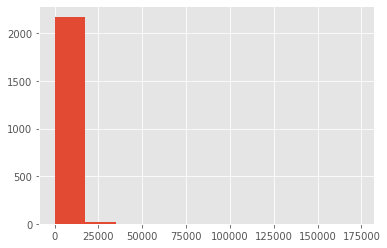

In [82]:
#Для GoneFludd
# Подгрузим данные из файлика 
with open('parsing_wall/GoneFludd.pickle', 'rb') as f:
    wall_gonefludd = pickle.load(f)
    
print(f'Кол-во: {len(wall_gonefludd)}')
    
text_len = [len(item['wall']) for item in wall_gonefludd if item['wall'] != None]
print('GoneFludd')
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.95)
wall_gonefludd = [item['wall'] for item in wall_gonefludd if item['wall'] != None and 100 < len(item['wall']) < q]
print(f'Оставшееся кол-во постов: {len(wall_gonefludd)}')

Кол-во: 2667
OldSchool
Оставшееся кол-во постов: 1710


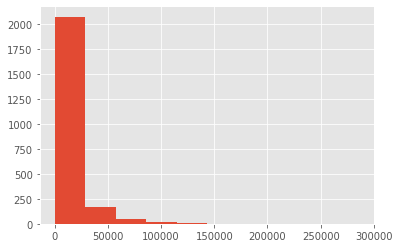

In [83]:
#Для OldSchool
# Подгрузим данные из файлика 
with open('parsing_wall/OldSchool.pickle', 'rb') as f:
    wall_oldschool = pickle.load(f)
    
print(f'Кол-во: {len(wall_oldschool)}')

text_len = [len(item['wall']) for item in wall_oldschool if item['wall'] != None]
print('OldSchool')
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.95)
wall_oldschool = [item['wall'] for item in wall_oldschool if item['wall'] != None and 100 < len(item['wall']) < q]
print(f'Оставшееся кол-во постов: {len(wall_oldschool)}')

Кол-во: 1750
Guf
Оставшееся кол-во постов: 1369


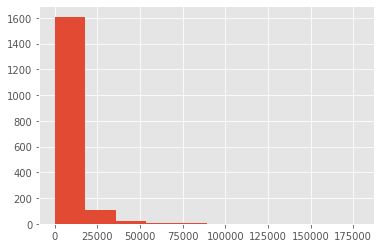

In [84]:
#Для Guf
# Подгрузим данные из файлика 
with open('parsing_wall/Guf.pickle', 'rb') as f:
    wall_guf = pickle.load(f)
    
print(f'Кол-во: {len(wall_guf)}')
    
text_len = [len(item['wall']) for item in wall_guf]
print('Guf')
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.95)
wall_guf = [item['wall'] for item in wall_guf if 100 < len(item['wall']) < q]
print(f'Оставшееся кол-во постов: {len(wall_guf)}')

Кол-во: 833
BigBabyTape
Оставшееся кол-во постов: 507


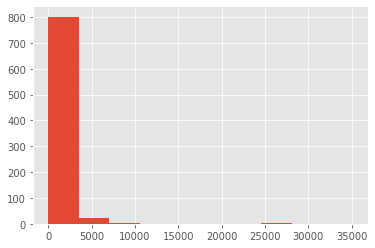

In [85]:
#Для Guf
# Подгрузим данные из файлика 
with open('parsing_wall/BigBabyTape.pickle', 'rb') as f:
    wall_bigbabytape = pickle.load(f)
    
print(f'Кол-во: {len(wall_bigbabytape)}')
    
text_len = [len(item['wall']) for item in wall_bigbabytape]
print('BigBabyTape')
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.95)
wall_bigbabytape = [item['wall'] for item in wall_bigbabytape if 100 < len(item['wall']) < q]
print(f'Оставшееся кол-во постов: {len(wall_bigbabytape)}')

In [86]:
del text_len

In [88]:
print(f'В группе NewSchool осталось {len(wall_newschool)} участников')
print(f'В группе GoneFludd осталось {len(wall_gonefludd)} участников')
print(f'В группе BigBabyTape осталось {len(wall_bigbabytape)} участников')
print()
print(f'В группе OldSchool осталось {len(wall_oldschool)} участников')
print(f'В группе Guf осталось {len(wall_guf)} участников')
print()
s = len(wall_newschool) + len(wall_gonefludd) + len(wall_oldschool) + len(wall_guf) + len(wall_bigbabytape)
print(f'Всего стен для анализа: {s}')

В группе NewSchool осталось 1129 участников
В группе GoneFludd осталось 1358 участников
В группе BigBabyTape осталось 507 участников

В группе OldSchool осталось 1710 участников
В группе Guf осталось 1369 участников

Всего стен для анализа: 6073


In [89]:
newschool = wall_newschool + wall_gonefludd + wall_bigbabytape
print(f'В выборке NewSchool теперь {len(newschool)} стен')

oldschool = wall_oldschool + wall_guf
print(f'В выборке OldSchool теперь {len(wall_oldschool)} стен')

В выборке NewSchool теперь 2994 стен
В выборке OldSchool теперь 1710 стен


In [90]:
del wall_gonefludd
del wall_bigbabytape
del wall_guf
del wall_newschool
del wall_oldschool

In [91]:
#Сохраним наши данные
with open('newschool.pickle', 'wb') as f:
    pickle.dump(newschool, f)
    
with open('oldchool.pickle', 'wb') as f:
    pickle.dump(oldschool, f)

OSError: [Errno 28] No space left on device

In [ ]:
#Очистим наши данные
with open('newschool.pickle', 'rb') as f:
    newschool = pickle.load(f)
    
with open('oldschool.pickle', 'rb') as f:
    oldschool = pickle.load(f)

In [70]:
#Выкинем пробелы и пунктуацию с наших данных
m = Mystem(entire_input=False)

In [71]:
%%time
print('Очищаем NewSchool')
newschool = [m.lemmatize(text) for text in newschool]

Очищаем NewSchool


RuntimeError: Problem has been occured. Current state:
text:
b'888 '
out:
b''

In [ ]:
%%time
print('Очищаем OldSchool')
oldschool = [m.lemmatize(text) for text in oldschool]

In [ ]:
#Сохраним очищенные данные
with open('clear_wall/newschool.pickle', 'wb') as f:
    pickle.dump(newschool, f)
    
with open('clear_wall/oldschool.pickle', 'wb') as f:
    pickle.dump(oldschool, f)